#### importation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv('data.csv')
print(df.head())
print(df.describe())
print(df.info())

   Order_ID  Distance_km Weather Traffic_Level Time_of_Day Vehicle_Type  \
0       522         7.93   Windy           Low   Afternoon      Scooter   
1       738        16.42   Clear        Medium     Evening         Bike   
2       741         9.52   Foggy           Low       Night      Scooter   
3       661         7.44   Rainy        Medium   Afternoon      Scooter   
4       412        19.03   Clear           Low     Morning         Bike   

   Preparation_Time_min  Courier_Experience_yrs  Delivery_Time_min  
0                    12                     1.0                 43  
1                    20                     2.0                 84  
2                    28                     1.0                 59  
3                     5                     1.0                 37  
4                    16                     5.0                 68  
          Order_ID  Distance_km  Preparation_Time_min  Courier_Experience_yrs  \
count  1000.000000  1000.000000           1000.000000 

In [3]:
print(df.isnull().sum())
cat_columns = df.select_dtypes(include='object').columns 
num_columns = df.select_dtypes(include=['int64', 'float64']).columns
for col in cat_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)
for col in num_columns:
    df[col].fillna(df[col].mean(), inplace=True)

print(df.isnull().sum())




Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64
Order_ID                  0
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64


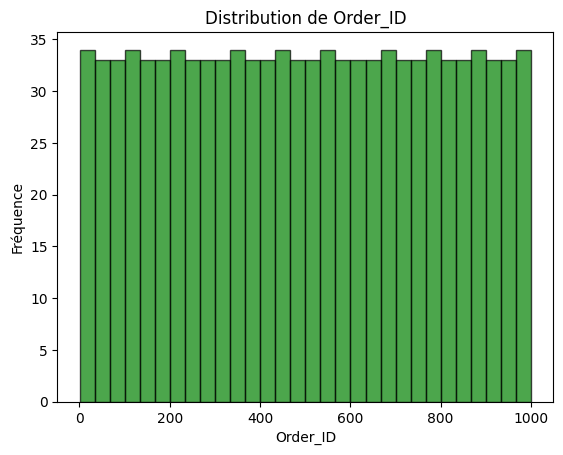

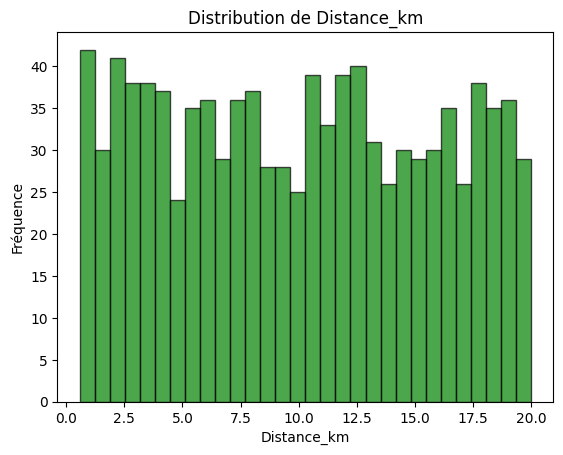

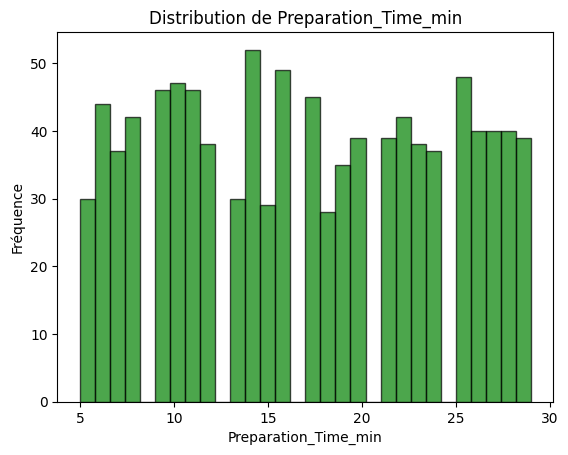

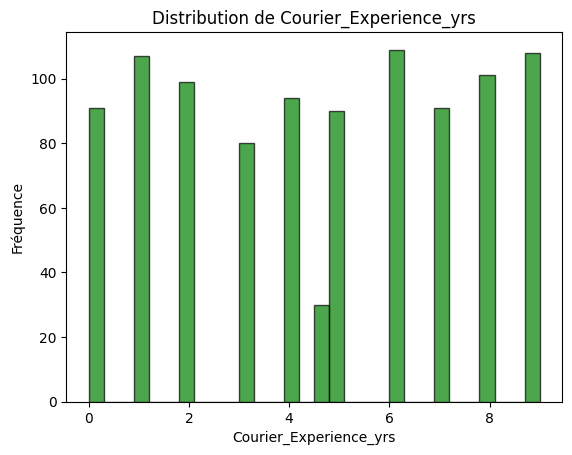

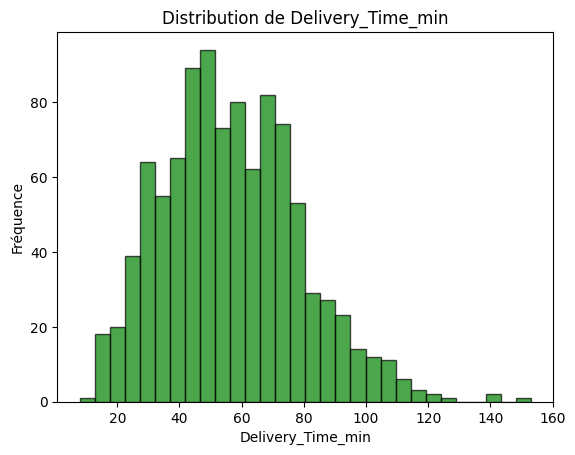

In [4]:
for col in num_columns:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7 ,color='green')
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Fréquence')
    plt.show()

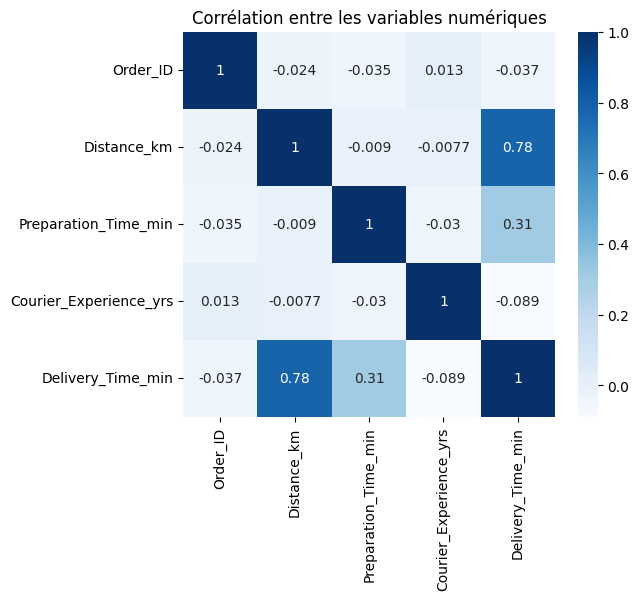

In [5]:
plt.figure(figsize=(6,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="Blues")
plt.title("Corrélation entre les variables numériques")
plt.show()

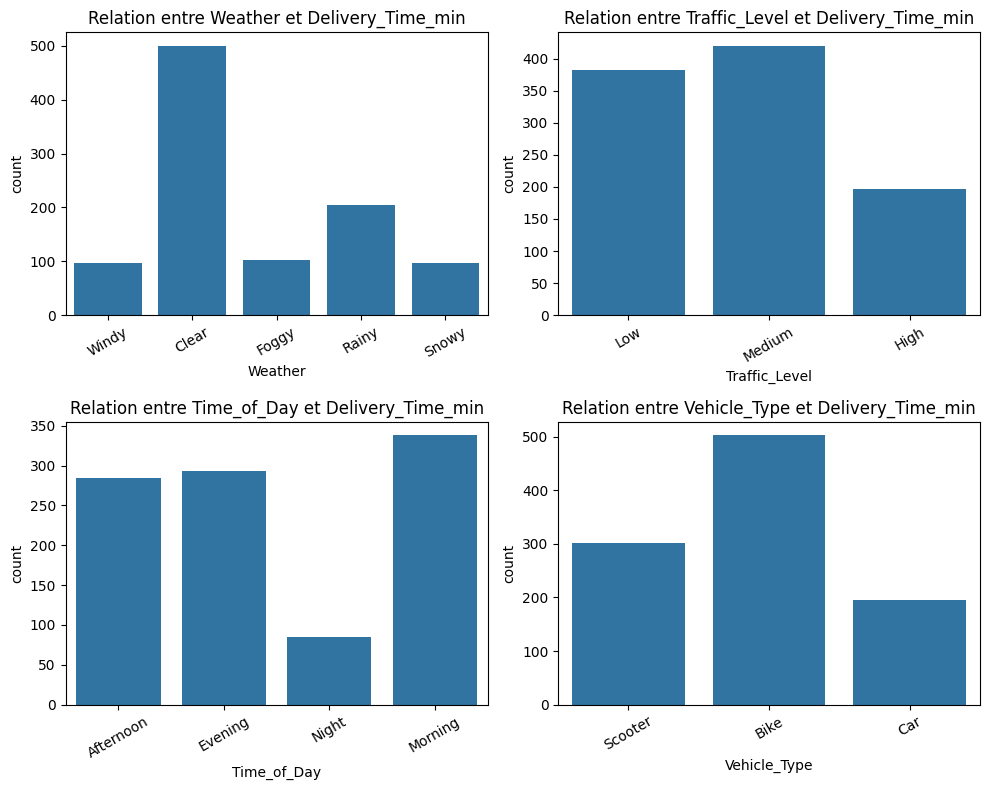

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
for i, col in enumerate(cat_columns):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"Relation entre {col} et Delivery_Time_min")
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()

plt.show()




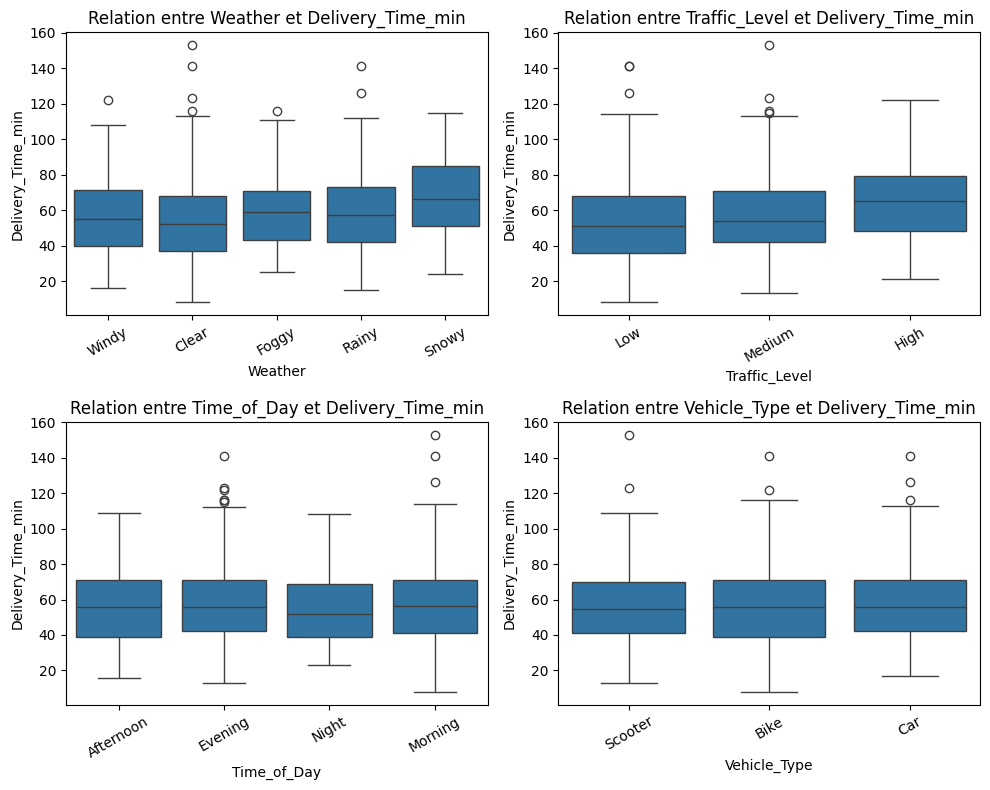

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
for i, col in enumerate(cat_columns):
    sns.boxplot(data=df, x=col, y="Delivery_Time_min", ax=axes[i])
    axes[i].set_title(f"Relation entre {col} et Delivery_Time_min")
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()

plt.show()

In [8]:

def encoded_df(df):
    df_encoded = df.copy()
    cat_encoded = df_encoded.select_dtypes(include='object').columns
    for col in cat_encoded:
        enc = OneHotEncoder(drop='first', sparse_output=False)
        encoded = enc.fit_transform(df_encoded[[col]]) 
        encoded_df = pd.DataFrame(encoded, columns=enc.get_feature_names_out([col]))
        df_encoded = pd.concat([df_encoded.drop(columns=[col]), encoded_df], axis=1)
    return df_encoded
df_encoded = encoded_df(df)
print(df_encoded.head())


   Order_ID  Distance_km  Preparation_Time_min  Courier_Experience_yrs  \
0       522         7.93                    12                     1.0   
1       738        16.42                    20                     2.0   
2       741         9.52                    28                     1.0   
3       661         7.44                     5                     1.0   
4       412        19.03                    16                     5.0   

   Delivery_Time_min  Weather_Foggy  Weather_Rainy  Weather_Snowy  \
0                 43            0.0            0.0            0.0   
1                 84            0.0            0.0            0.0   
2                 59            1.0            0.0            0.0   
3                 37            0.0            1.0            0.0   
4                 68            0.0            0.0            0.0   

   Weather_Windy  Traffic_Level_Low  Traffic_Level_Medium  \
0            1.0                1.0                   0.0   
1            0.0  

In [9]:

target_col = 'Delivery_Time_min'
col_to_drop = ['Order_ID', 'Courier_Experience_yrs']

X = df_encoded.drop(columns=[target_col]+col_to_drop)
y = df_encoded[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(type(X_train))


(800, 13) (200, 13) (800,) (200,)
<class 'pandas.core.frame.DataFrame'>


In [10]:

def normalisation_data(X_train, X_test, column_to_scale):
    scaler = StandardScaler()
    
    # Fit only on the selected columns of X_train
    X_train[column_to_scale] = scaler.fit_transform(X_train[column_to_scale])
    X_test[column_to_scale] = scaler.transform(X_test[column_to_scale])
    
    return X_train, X_test

# Example usage
column_to_scale = ['Distance_km', 'Preparation_Time_min']
X_train_scaled, X_test_scaled = normalisation_data(X_train.copy(), X_test.copy(), column_to_scale)
X_train_scaled,X_test_scaled = normalisation_data(X_train, X_test,column_to_scale)
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [11]:
from sklearn.feature_selection import SelectKBest, f_regression
def feature_selection(X, y, num_features=5):
    selector = SelectKBest(score_func=f_regression, k=num_features)
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()]
    return X_selected, selected_features


X_train_selected, selected_features = feature_selection(X_train_scaled, y_train, num_features=5)

print(" Selected features:", list(selected_features))

 Selected features: ['Distance_km', 'Preparation_Time_min', 'Weather_Rainy', 'Weather_Snowy', 'Traffic_Level_Low']


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [None , 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
scoring={'MAE':make_scorer(mean_absolute_error ,greater_is_better=False)}
model=RandomForestRegressor(random_state=0)

grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=5, n_jobs=-1, scoring=scoring, refit='MAE')
grid_search.fit(X_train_selected, y_train)
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


In [13]:
y_pred = best_model.predict(X_test_scaled[selected_features])
mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae)
r2 = best_model.score(X_test_scaled[selected_features], y_test)
print("Test R²:", r2)


Test MAE: 7.656410530492556
Test R²: 0.7329091157906253


d:\Brief_02\brief02\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
d:\Brief_02\brief02\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [14]:
from sklearn.svm import SVR

SVR_PARAMS = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}
SVR_scoring = {'MAE': make_scorer(mean_absolute_error, greater_is_better=False)}

model_svr = SVR()
grid_search_svr = GridSearchCV(estimator=model_svr, param_grid=SVR_PARAMS, cv=5, n_jobs=-1, scoring=SVR_scoring, refit='MAE')
grid_search_svr.fit(X_train_selected, y_train)
best_model_svr = grid_search_svr.best_estimator_
print("Best SVR parameters:", grid_search_svr.best_params_)



Best SVR parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}


In [15]:
y_pred_svr = best_model_svr.predict(X_test_scaled[selected_features])
mae_svr = mean_absolute_error(y_test, y_pred_svr)
print("Test SVR MAE:", mae_svr)
r2_svr = best_model_svr.score(X_test_scaled[selected_features], y_test)
print("Test SVR R²:", r2_svr)

Test SVR MAE: 6.61909512027792
Test SVR R²: 0.7737507503910166


d:\Brief_02\brief02\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
d:\Brief_02\brief02\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


## Pipeline

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


target_col = 'Delivery_Time_min'
col_to_drop = ['Order_ID', 'Courier_Experience_yrs']
X = df.drop(columns=[target_col]+col_to_drop)
y = df[target_col]

cat_col = X.select_dtypes(include='object').columns
num_col = X.select_dtypes(include=['int64', 'float64']).columns


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_col),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_col)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

rf_param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
}

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, n_jobs=-1)
rf_grid.fit(X_train, y_train)

rf_best = rf_grid.best_estimator_
rf_preds = rf_best.predict(X_test)
r2_score_rf = rf_best.score(X_test, y_test)

print("Best Params:", rf_grid.best_params_)
print("MAE:", mean_absolute_error(y_test, rf_preds))
print("R²:", r2_score_rf)


Best Params: {'model__max_depth': 10, 'model__n_estimators': 100}
MAE: 7.039528329698697
R²: 0.7774009139436637


In [19]:
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVR())
])

svr_param_grid = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto']
}

svr_grid = GridSearchCV(svr_pipeline, svr_param_grid, cv=5, n_jobs=-1)
svr_grid.fit(X_train, y_train)


svr_best = svr_grid.best_estimator_
svr_preds = svr_best.predict(X_test)
r2_score_svr = svr_best.score(X_test, y_test)


print("Best Params:", svr_grid.best_params_)
print("MAE:", mean_absolute_error(y_test, svr_preds))
print("R²:", r2_score_svr)

Best Params: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'linear'}
MAE: 6.078665496797007
R²: 0.8141890354783725
